# PyTorch Custom Datasets
Reference book --> https://www.learnpytorch.io/04_pytorch_custom_datasets/

We've used the datasets which PyTorch provides, but how to use our own data for training and testing? Let's find out

## Domain Libraries
Depending on what kind problem we're working on, text, audio, vision, recommendation, we'll look into PyTorch domain libraries for existing data loading functions and customizable data loading functions.

We're working on a vision problem, so we'll be checking out the custom data loading functions for `torchvision`.

## 0. Importing PyTorch and setting up device agnostic code


In [2]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [3]:
# Setup device agnostic code
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## 1. Get Data
Our dataset is the subset of Food101 dataset.

Food101 has 101 different classes of food and 1000 images per class. (750 testing, 250 training).

Our dataset has only 3 classes of images and 10% of the data (75 testing images, 25 training images). We're doing this to speed up our experiments as larger dataset would take too long for computation.

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder.
data_path = Path('data/')
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download and unzip
if image_path.is_dir():
  print(f'{image_path} already exists... Skipping Download.')
else:
  print(f'{image_path} does not exist. Creating directory...')
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data, wb=write binary
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  # Unzip pizza, steak, sushi data, r=read mode.
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

data/pizza_steak_sushi already exists... Skipping Download.


## 2. Becoming one with the data (data preparation and exploration)

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir path returning it's contents.
  """

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


We have PyTorch's [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) which we're going to use to load our data. So, our data is to be stored in the format mentioned in the documentation.

In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

What we have to do:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name from `pathlib.Path.parent.stem`
4. Let's open the image from python's image library `PIL`
5. Show the image and print metadata

data/pizza_steak_sushi/train/sushi/2120573.jpg
sushi
Random image path: data/pizza_steak_sushi/train/sushi/2120573.jpg
Image class: sushi
Image height: 512
Image width: 384


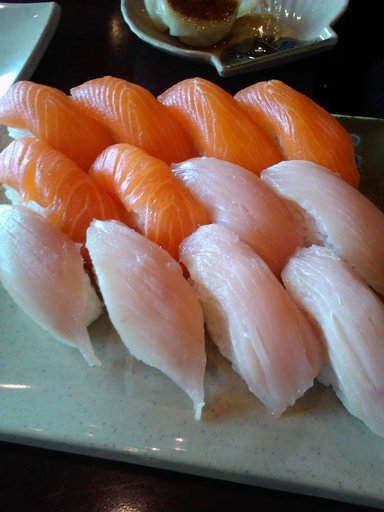

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the img class is name of directory in which it's stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

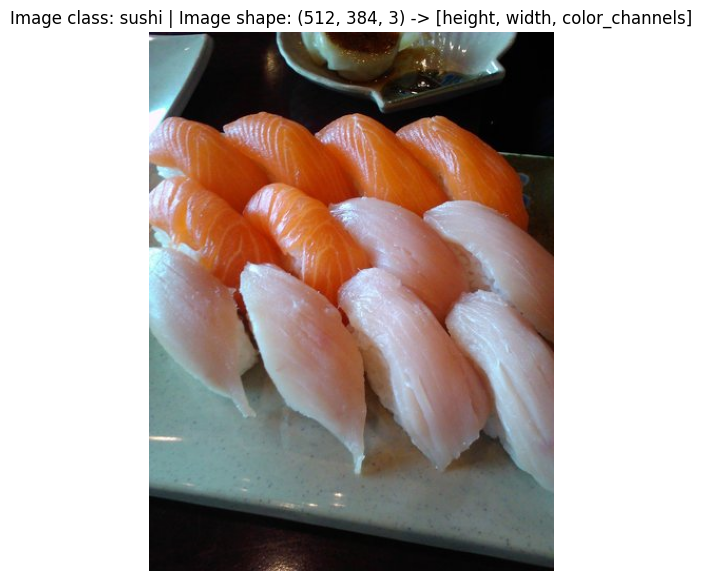

In [10]:
# Try to visualize the image with matplotlib.
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]')
plt.axis(False);

array([[[26, 21, 44],
        [25, 20, 43],
        [24, 19, 41],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[21, 16, 39],
        [20, 15, 37],
        [22, 17, 39],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[69, 61, 84],
        [62, 54, 75],
        [51, 46, 66],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[11,  9, 10],
        [10,  8,  9],
        [ 9,  7,  8],
        ...,
        [14, 13, 11],
        [17, 13, 14],
        [16, 12, 11]],

       [[ 8,  8,  8],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [11,  7,  4],
        [12,  6,  6],
        [12,  7,  4]],

       [[ 8,  8,  8],
        [ 8,  8,  8],
        [ 9,  9,  9],
        ...,
        [10,  6,  3],
        [12,  7,  4],
        [12,  7,  4]]], dtype=uint8)
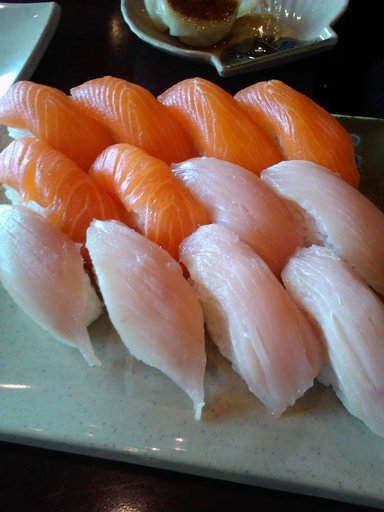

In [11]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch -
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently into `torch.utils.data.DataLoader`

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to work with the model. They also help with data augmentation.
[`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) documentation.

In [13]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to same size
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal (augmentation)
    transforms.RandomHorizontalFlip(p=0.5),  # Flips img 50% of times
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

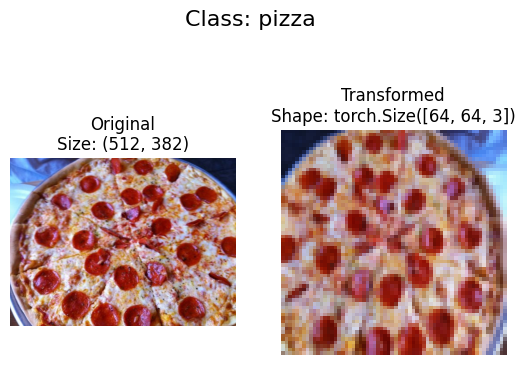

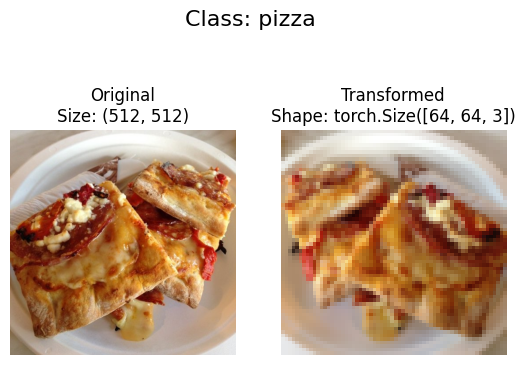

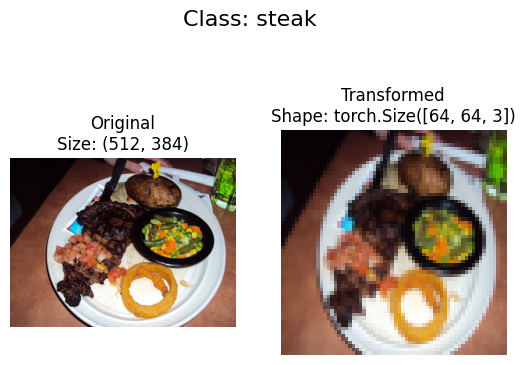

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis(False)

      # Transform and plot target image
      # This throws errror. # matplotlib expects height, width, color channels. This is channels, height, width.
      # transformed_image = transform(f)
      transformed_image = transform(f).permute(1, 2, 0) # Changes to HWC.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html).

In [16]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # A transform for the data
                                  target_transform = None)  # A transform for the target (label)

test_data = datasets.ImageFolder(root = test_dir, transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check lengths of datasets
len(train_data), len(test_data)

(225, 75)

In [21]:
# Looking at the first sample.
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [23]:
# Index on train_data Dataset to get a single image and it's label
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [32]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: \n{img}')
print(f'Image tensor shape: {img.shape}')
print(f'Image tensor type: {img.dtype}')

Image tensor: 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

In [33]:
print(f'Label: {label}')
print(f'Label datatype: {type(label)}') # The label is a scalar value. It's not a tensor.
print(f'Label class: {class_names[label]}') # Getting class name from label.

Label: 0
Label datatype: <class 'int'>
Label class: pizza


Image tensor shape: torch.Size([3, 64, 64]) --> [color_channels, height, width]
Permuted image tensor shape: torch.Size([64, 64, 3]) --> [height, width, color_channels]


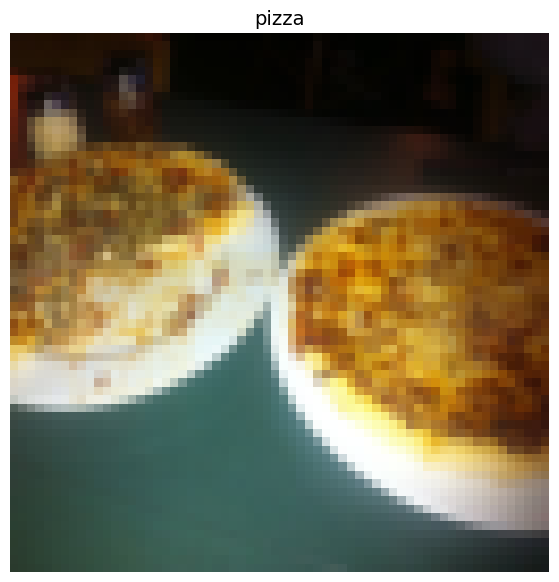

In [35]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f'Image tensor shape: {img.shape} --> [color_channels, height, width]')
print(f'Permuted image tensor shape: {img_permute.shape} --> [height, width, color_channels]')

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize = 14);

### 4.1 Turn loaded datasets into `DataLoader`(s)

A `DataLoader` is going to help us turn out `Dataset`s into iterables and we can customize the `BATCH_SIZE` to make our model see a fixed number of images in a single iteration instead of feeding it all the images at once.

In [38]:
import os
os.cpu_count()

2

In [43]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers=os.cpu_count(), shuffle=False)

In [44]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78e5f87005e0>,
 <torch.utils.data.dataloader.DataLoader at 0x78e5f8702530>)

In [45]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [47]:
img, label = next(iter(train_dataloader))

# You can change the batch size to a different number. Here it's 1 as shown in batch dimension.
print(f'Image shape: {img.shape} --> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape} --> [batch_size]')

Image shape: torch.Size([1, 3, 64, 64]) --> [batch_size, color_channels, height, width]
Label shape: torch.Size([1]) --> [batch_size]


## 5. Option 2: Loading image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset.
3. Want to be able to get classes as dictionary from the dataset.

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:
* Eventhough you could create a `Dataset` out of almost anything, it doesn't mean it will work
* Creating custom `Dataset` requires writing more code, which could lead to errors or performance issues.

Almost all custom datasets in PyTorch subclass [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

In [48]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [50]:
# Instance of torchvision.datasets.ImageFolder()
# We want to recreate this functionality using our own custom Dataset.
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get the class names

We want the function to:
- Get class names using `os.scandir()` to traverse a target directory (ideally, the directory is in standard image classification format)
- Raise an error if class names aren't found (if this happens, there must be something wrong with directory structure)
- Turn class names into a dict and list and return them.

In [53]:
# Checking what scandir does -
list(os.scandir(train_dir))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

[`os.scandir()`](https://www.geeksforgeeks.org/python-os-scandir-method/) ->
Like `listdir`, `scandir` calls the operating system’s directory iteration system calls to get the names of the files in the given `path`, but it’s different from `listdir` in two ways:

1. Instead of returning bare filename strings, it returns lightweight `DirEntry` objects that hold the filename string and provide simple methods that allow access to the additional data the operating system may have returned.
2. It returns a generator instead of a list, so that `scandir` acts as a true iterator instead of returning the full list immediately.

Basically, it returns the names of all the directories and files in the provided path as `DirEntry` objects. We put all the objects into a list and iterate through each entry in the list. `DirEntry` objects have attribute `name` which gives us the name of the directory/file.

In [51]:
# Setup path for target directory
target_directory = train_dir
print(f'Target directory: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [54]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Input:
  directory: The directory containing the data.
  Output:
  Returns a tuple containing a list of class names and a dictionary with class names mapped to respective indices(targets)
  """
  # 1. Get class names by scanning the target directory
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

  # 2. Raise an error if class names are not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure")

  # 3. Create a dictionary which maps classes to indices.
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [55]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create custom `Dataset` to replicate `ImageFolder`

To create a custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our own subclass with a target directory (the directory we'd like to get the data from) as well as a transform if we'd like to transform our data.
3. Create several attributes -
  * paths - paths of our images
  * transforms - transforms we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of target classes mapped to indices
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of our dataset.
6. Overwrite the `__getitem__()` method to return a given sample when passed an index.

In [67]:
# Write custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialize our class with target directory and transforms
  def __init__(self,
               targ_dir: str,
               transform = None):
    super().__init__()

    # 3. Create class attributes.
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    # Setup transforms
    self.transform = transform
    # Use helper function to get classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create function to load images
  def load_images(self, index: int) -> Image.Image:
    """ Opens an image via a path and returns it. """
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite the len method to get length of our dataset.
  def __len__(self) -> int:
    """ Returns the total number of images in our dataset. """
    return len(self.paths)

  # 6. Overwrite __getitem__() method. This decides what to return when indexing.
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_images(index) # Not converting to tensor. Will do it in transforms.
    target_class = self.paths[index].parent.name  # Returns the name of the parent directory of the image, which is the target/label.
    class_idx = self.class_to_idx[target_class]

    # Transform if necessary
    if self.transform:
      img = self.transform(img)

    return img, class_idx

In [68]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [69]:
# Testing our custom datasets
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
test_data_custom = ImageFolderCustom(test_dir, test_transforms)

In [70]:
train_data_custom[0]

(tensor([[[0.4745, 0.5333, 0.5412,  ..., 0.2784, 0.2627, 0.1922],
          [0.5882, 0.5176, 0.5608,  ..., 0.3804, 0.3647, 0.2667],
          [0.5451, 0.4902, 0.5451,  ..., 0.3686, 0.3529, 0.2941],
          ...,
          [0.6314, 0.6667, 0.6902,  ..., 0.4588, 0.4627, 0.4235],
          [0.6157, 0.6588, 0.6745,  ..., 0.4235, 0.4118, 0.4039],
          [0.6118, 0.6431, 0.6667,  ..., 0.4039, 0.3765, 0.3608]],
 
         [[0.4235, 0.4549, 0.4784,  ..., 0.2471, 0.2471, 0.1882],
          [0.5294, 0.4314, 0.6118,  ..., 0.3373, 0.3137, 0.2039],
          [0.4627, 0.4078, 0.5294,  ..., 0.3059, 0.2667, 0.1686],
          ...,
          [0.6118, 0.6353, 0.6549,  ..., 0.3529, 0.3216, 0.2471],
          [0.6196, 0.6314, 0.6431,  ..., 0.2471, 0.2275, 0.2157],
          [0.6196, 0.6353, 0.6431,  ..., 0.1922, 0.1843, 0.1843]],
 
         [[0.6196, 0.5882, 0.6000,  ..., 0.3686, 0.4235, 0.3137],
          [0.6784, 0.5647, 0.7490,  ..., 0.4745, 0.4510, 0.2824],
          [0.5451, 0.5373, 0.6745,  ...,

In [71]:
train_data_custom.class_to_idx, train_data_custom.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [72]:
len(train_data_custom), len(test_data_custom)

(225, 75)